In [62]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import numpy as np

nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

import json
import csv

from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
brands = [
  "latvenergo",
  "rimi",
  "maxima",
  "swedbank",
  "lmt",
  "tet",
  "lg",
  "tele2",
  "airbaltic",
  "olympic",
  "seb",
  "grindeks",
  "citadele",
  "bite",
  "drogas",
  "depo",
  "circlek",
  "lb",
  "optibet",
  "evolution",
];

In [3]:
allLabeledTweets = pd.read_csv('./tweets/allLabeledTweets.csv')
allLabeledTweets.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,retweetedId,retweetCount,label,message_lowercase,clean_message,clean_message_no_punct,clean_message_no_stopwords_from_list,clean_message_no_punct_no_stopwords_from_list,clean_message_no_punct_no_freq_stopwords,clean_message_no_freq_stopwords
0,Tiek vērtēti trīs potenciālie airBaltic invest...,1478404,925617390523732000,2017-11-01T08:55:57,lv,NaN,NaN,NaN,24855060,Dienas Bizness,...,NaN,0,0,tiek vērtēti trīs potenciālie airbaltic invest...,tiek vērtēti trīs potenciālie airbaltic invest...,tiek vērtēti trīs potenciālie airbaltic invest...,vērtēti trīs potenciālie airbaltic investori U...,vērtēti trīs potenciālie airbaltic investori U...,tiek vērtēti trīs potenciālie airbaltic invest...,tiek vērtēti trīs potenciālie airbaltic invest...
1,"Vakardien, vēlu vakarā, ar svinīgu pasākumu ti...",1486476,924948828318511100,2017-10-30T12:39:20,lv,NaN,NaN,NaN,44849531,RIGA I Airport,...,NaN,0,0,"vakardien, vēlu vakarā, ar svinīgu pasākumu ti...","vakardien, vēlu vakarā, ar svinīgu pasākumu ti...",vakardien vēlu vakarā ar svinīgu pasākumu ti...,"vakardien , vēlu vakarā , svinīgu pasākumu atk...",vakardien vēlu vakarā svinīgu pasākumu atklāts...,vakardien vēlu vakarā svinīgu pasākumu tika at...,"vakardien , vēlu vakarā , svinīgu pasākumu tik..."
2,"Es ļoti ceru,ka potenciālie Air Baltic investo...",1488297,925794560420311000,2017-11-01T20:39:58,lv,NaN,NaN,NaN,218804015,Artis Pabriks,...,NaN,9,2,"es ļoti ceru,ka potenciālie air baltic investo...","es ļoti ceru,ka potenciālie air baltic investo...",es ļoti ceru ka potenciālie air baltic investo...,"es ļoti ceru , potenciālie air baltic investor...",es ļoti ceru potenciālie air baltic investori ...,ļoti ceru potenciālie air baltic investori nav...,"ļoti ceru , potenciālie air baltic investori n..."
3,Ar kritisko domāšanu gan joprojām bēdīgi. Piln...,1489818,925045141018218500,2017-10-30T19:02:02,lv,NaN,NaN,NaN,21071644,Andris Rubīns,...,NaN,3,2,ar kritisko domāšanu gan joprojām bēdīgi. piln...,ar kritisko domāšanu gan joprojām bēdīgi. piln...,ar kritisko domāšanu gan joprojām bēdīgi piln...,kritisko domāšanu joprojām bēdīgi . pilns face...,kritisko domāšanu joprojām bēdīgi pilns facebo...,kritisko domāšanu joprojām bēdīgi pilns facebo...,kritisko domāšanu joprojām bēdīgi . pilns face...
4,Latvijas lidsabiedrība airBaltic sadarbībā ar ...,1490250,925006964135952400,2017-10-30T16:30:20,lv,NaN,NaN,NaN,131562098,Latviesi.com,...,NaN,0,0,latvijas lidsabiedrība airbaltic sadarbībā ar ...,latvijas lidsabiedrība airbaltic sadarbībā ar ...,latvijas lidsabiedrība airbaltic sadarbībā ar ...,latvijas lidsabiedrība airbaltic sadarbībā apv...,latvijas lidsabiedrība airbaltic sadarbībā apv...,latvijas lidsabiedrība airbaltic sadarbībā apv...,latvijas lidsabiedrība airbaltic sadarbībā apv...


In [4]:
allLabeledTweets["label"].value_counts()

0    253
2    136
1     87
Name: label, dtype: int64

### Features

In [36]:
def getWordFrequencyWithoutBrands(message):
    tweets = pd.read_csv('./tweets/allLabeledTweets.csv')

    allPostsConcat = ''
    for tweet in tweets[message]:
        if(type(tweet)==str):
            allPostsConcat+=' '+ tweet

    # create bag-of-words
    all_words = []

    words = word_tokenize(allPostsConcat)
    words = [word for word in words if not word in brands]
    for word in words:
        if word!='``' and word!="''" and len(word) > 1:
            all_words.append(word)

    all_words = nltk.FreqDist(all_words)
    
    return all_words

In [57]:
# function to find features in every post
def find_features(post, tweet_features):
    words = word_tokenize(post)
    features = {}
    for word in tweet_features:
        features[word] = (word in words)
    return features

### Get training, testing data

In [38]:
from sklearn import model_selection

train_df, test_df = model_selection.train_test_split(allLabeledTweets, test_size=0.1)
train_df.shape, test_df.shape

((428, 25), (48, 25))

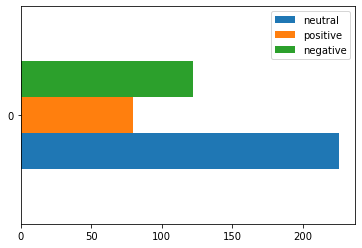

In [39]:
train_neutral = train_df[train_df["label"] == 0]
train_positive = train_df[train_df["label"] == 1]
train_negative = train_df[train_df["label"] == 2]

pd.DataFrame(dict(
  neutral=[len(train_neutral)],
  positive=[len(train_positive)],
  negative=[len(train_negative)]  
)).plot(kind='barh');

In [40]:
train_df = pd.concat([
    train_neutral.sample(75),
    train_positive,
    train_negative.sample(75)])

train_df.shape, test_df.shape

((230, 25), (48, 25))

### Lowercase raw tweets

In [7]:
freqWordsLowercase = getWordFrequencyWithoutBrands('message_lowercase')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsLowercase)))
print('Most common words: {}'.format(freqWordsLowercase.most_common(100)))

word_features_lowercase = list(freqWordsLowercase.keys())[:1500]

Number of words: 4538
Most common words: [('https', 476), ('un', 191), ('ir', 118), ('ar', 117), ('par', 111), ('no', 79), ('ka', 73), ('uz', 49), ('jau', 49), ('vai', 48), ('arī', 43), ('kā', 42), ('kas', 41), ('kopā', 40), ('latvijas', 39), ('vēl', 39), ('pēc', 38), ('bet', 38), ('circleklatvija', 35), ('nav', 34), ('lieliskamūzika', 34), ('17-18', 34), ('►https', 34), ('//t.co/jymqnspivg', 34), ('skaties', 31), ('...', 29), ('to', 28), ('bitelv', 28), ('tā', 26), ('tiešraide', 26), ('lhf', 25), ('pie', 24), ('kopāspēks', 24), ('spēli', 24), ('ja', 23), ('es', 22), ('tas', 22), ('tad', 22), ('šeit', 22), ('maximaveikals', 22), ('būs', 20), ('the', 20), ('lielfans', 19), ('minūtēm', 19), ('lai', 18), ('tagad', 18), ('man', 17), ('šodien', 17), ('tikai', 16), ('hokeja', 16), ('ļoti', 15), ('rīgas', 15), ('mūsu', 15), ('oik', 15), ('līga', 15), ('kad', 14), ('eiro', 14), ('30', 14), ('gada', 13), ('var', 13), ('dblv', 13), ('ne', 12), ('izlase', 12), ('nekā', 12), ('manslmt', 12), ('gan

In [58]:
tweets_train = list(zip(train_df.loc[:,"message_lowercase"].values,train_df.loc[:,"label"].values))
featuresets_train = [(find_features(text, word_features_lowercase), label) for (text, label) in tweets_train]

tweets_test = list(zip(test_df.loc[:,"message_lowercase"].values,test_df.loc[:,"label"].values))
featuresets_test = [(find_features(text, word_features_lowercase), label) for (text, label) in tweets_test]

In [60]:
nltk_model = SklearnClassifier(MultinomialNB())
nltk_model.train(featuresets_train)
accuracy = nltk.classify.accuracy(nltk_model, featuresets_test)*100
print("{} Accuracy: {}".format("Naive Bayes", accuracy))

Naive Bayes Accuracy: 58.333333333333336


In [63]:
txt_features, labels = zip(*featuresets_test)

prediction = nltk_model.classify_many(txt_features)
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
    columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

              precision    recall  f1-score   support

           0       0.82      0.52      0.64        27
           1       0.25      0.29      0.27         7
           2       0.52      0.86      0.65        14

    accuracy                           0.58        48
   macro avg       0.53      0.55      0.52        48
weighted avg       0.65      0.58      0.59        48



predicted                  
                  neutral positive negative
actual neutral         14        6        7
       positive         1        2        4
       negative         2        0       12

### Cleaned tweets

In [8]:
freqWordsClean = getWordFrequencyWithoutBrands('clean_message')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsClean)))
print('Most common words: {}'.format(freqWordsClean.most_common(100)))

word_features_clean = list(freqWordsClean.keys())[:1500]

Number of words: 3862
Most common words: [('URL', 510), ('MENTION', 329), ('NMBR', 324), ('un', 191), ('ir', 118), ('ar', 117), ('par', 111), ('no', 79), ('ka', 73), ('uz', 49), ('jau', 49), ('vai', 48), ('arī', 43), ('kā', 42), ('kas', 41), ('kopā', 40), ('latvijas', 39), ('vēl', 39), ('pēc', 38), ('bet', 38), ('nav', 34), ('lieliskamūzika', 34), ('skaties', 31), ('...', 29), ('to', 28), ('tā', 26), ('tiešraide', 26), ('lhf', 25), ('pie', 24), ('kopāspēks', 24), ('spēli', 24), ('ja', 23), ('es', 22), ('tas', 22), ('tad', 22), ('šeit', 22), ('būs', 20), ('the', 20), ('lielfans', 19), ('minūtēm', 19), ('lai', 18), ('tagad', 18), ('man', 17), ('šodien', 17), ('tikai', 16), ('hokeja', 16), ('ļoti', 15), ('rīgas', 15), ('mūsu', 15), ('oik', 15), ('līga', 15), ('kad', 14), ('eiro', 14), ('gada', 13), ('var', 13), ('ne', 12), ('izlase', 12), ('nekā', 12), ('gan', 11), ('pret', 11), ('vairāk', 11), ('dienasbizness', 11), ('ielā', 11), ('tv', 11), ('kur', 10), ('darbinieku', 10), ('latvija', 1

In [64]:
tweets_train = list(zip(train_df.loc[:,"clean_message"].values,train_df.loc[:,"label"].values))
featuresets_train = [(find_features(text, word_features_clean), label) for (text, label) in tweets_train]

tweets_test = list(zip(test_df.loc[:,"clean_message"].values,test_df.loc[:,"label"].values))
featuresets_test = [(find_features(text, word_features_clean), label) for (text, label) in tweets_test]

nltk_model = SklearnClassifier(MultinomialNB())
nltk_model.train(featuresets_train)
accuracy = nltk.classify.accuracy(nltk_model, featuresets_test)*100
print("{} Accuracy: {}".format("Naive Bayes", accuracy))

txt_features, labels = zip(*featuresets_test)

prediction = nltk_model.classify_many(txt_features)
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
    columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Naive Bayes Accuracy: 60.416666666666664
              precision    recall  f1-score   support

           0       0.88      0.56      0.68        27
           1       0.25      0.29      0.27         7
           2       0.52      0.86      0.65        14

    accuracy                           0.60        48
   macro avg       0.55      0.57      0.53        48
weighted avg       0.68      0.60      0.61        48



predicted                  
                  neutral positive negative
actual neutral         15        5        7
       positive         1        2        4
       negative         1        1       12

### No punctuation

In [9]:
freqWordsCleanNoPunct = getWordFrequencyWithoutBrands('clean_message_no_punct')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsCleanNoPunct)))
print('Most common words: {}'.format(freqWordsCleanNoPunct.most_common(100)))

word_features_clean_no_punct = list(freqWordsCleanNoPunct.keys())[:1500]

Number of words: 3834
Most common words: [('URL', 510), ('MENTION', 329), ('NMBR', 324), ('un', 191), ('ir', 118), ('ar', 117), ('par', 111), ('no', 80), ('ka', 73), ('uz', 50), ('jau', 49), ('vai', 48), ('arī', 43), ('kā', 42), ('kas', 41), ('vēl', 40), ('kopā', 40), ('latvijas', 39), ('pēc', 38), ('bet', 38), ('nav', 34), ('lieliskamūzika', 34), ('skaties', 31), ('to', 28), ('tā', 26), ('tiešraide', 26), ('lhf', 25), ('pie', 24), ('kopāspēks', 24), ('spēli', 24), ('ja', 23), ('es', 22), ('tas', 22), ('tad', 22), ('šeit', 22), ('būs', 20), ('the', 20), ('lielfans', 19), ('minūtēm', 19), ('lai', 18), ('tagad', 18), ('man', 17), ('šodien', 17), ('tikai', 16), ('hokeja', 16), ('ļoti', 15), ('rīgas', 15), ('mūsu', 15), ('oik', 15), ('līga', 15), ('kad', 14), ('eiro', 14), ('gada', 13), ('var', 13), ('ne', 12), ('izlase', 12), ('nekā', 12), ('gan', 11), ('pret', 11), ('vairāk', 11), ('dienasbizness', 11), ('ielā', 11), ('tv', 11), ('kur', 10), ('darbinieku', 10), ('latvija', 10), ('amp', 1

In [65]:
tweets_train = list(zip(train_df.loc[:,"clean_message_no_punct"].values,train_df.loc[:,"label"].values))
featuresets_train = [(find_features(text, word_features_clean_no_punct), label) for (text, label) in tweets_train]

tweets_test = list(zip(test_df.loc[:,"clean_message_no_punct"].values,test_df.loc[:,"label"].values))
featuresets_test = [(find_features(text, word_features_clean_no_punct), label) for (text, label) in tweets_test]

nltk_model = SklearnClassifier(MultinomialNB())
nltk_model.train(featuresets_train)
accuracy = nltk.classify.accuracy(nltk_model, featuresets_test)*100
print("{} Accuracy: {}".format("Naive Bayes", accuracy))

txt_features, labels = zip(*featuresets_test)

prediction = nltk_model.classify_many(txt_features)
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
    columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Naive Bayes Accuracy: 60.416666666666664
              precision    recall  f1-score   support

           0       0.88      0.56      0.68        27
           1       0.29      0.29      0.29         7
           2       0.50      0.86      0.63        14

    accuracy                           0.60        48
   macro avg       0.56      0.57      0.53        48
weighted avg       0.68      0.60      0.61        48



predicted                  
                  neutral positive negative
actual neutral         15        4        8
       positive         1        2        4
       negative         1        1       12

### Stopwords

#### From list

##### With punctuation

In [11]:
freqWordsCleanNoStopwordsFromList = getWordFrequencyWithoutBrands('clean_message_no_stopwords_from_list')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsCleanNoStopwordsFromList)))
print('Most common words: {}'.format(freqWordsCleanNoStopwordsFromList.most_common(100)))

word_features_clean_no_stopwords_from_list = list(freqWordsCleanNoStopwordsFromList.keys())[:1500]

Number of words: 3787
Most common words: [('URL', 510), ('MENTION', 329), ('NMBR', 324), ('kas', 41), ('kopā', 40), ('latvijas', 39), ('vēl', 39), ('nav', 34), ('lieliskamūzika', 34), ('skaties', 31), ('...', 29), ('to', 28), ('tiešraide', 26), ('lhf', 25), ('kopāspēks', 24), ('spēli', 24), ('es', 22), ('tas', 22), ('šeit', 22), ('the', 20), ('lielfans', 19), ('minūtēm', 19), ('tagad', 18), ('man', 17), ('šodien', 17), ('hokeja', 16), ('ļoti', 15), ('rīgas', 15), ('mūsu', 15), ('oik', 15), ('līga', 15), ('kad', 14), ('eiro', 14), ('gada', 13), ('izlase', 12), ('vairāk', 11), ('dienasbizness', 11), ('ielā', 11), ('tv', 11), ('kur', 10), ('darbinieku', 10), ('latvija', 10), ('amp', 10), ('ko', 10), ('vietas', 9), ('varētu', 9), ('kāpēc', 9), ('kāds', 9), ('valsts', 9), ('u-', 9), ('lauvassirds', 9), ('paldies', 9), ('rīgā', 9), ('telpu', 9), ('darbu', 9), ('jaunajā', 9), ('virslīga', 9), ('nevar', 8), ('neko', 8), ('visu', 8), ('jums', 8), ('dblv', 8), ('bankas', 8), ('elektrības', 8), (

In [66]:
tweets_train = list(zip(train_df.loc[:,"clean_message_no_stopwords_from_list"].values,train_df.loc[:,"label"].values))
featuresets_train = [(find_features(text, word_features_clean_no_stopwords_from_list), label) for (text, label) in tweets_train]

tweets_test = list(zip(test_df.loc[:,"clean_message_no_stopwords_from_list"].values,test_df.loc[:,"label"].values))
featuresets_test = [(find_features(text, word_features_clean_no_stopwords_from_list), label) for (text, label) in tweets_test]

nltk_model = SklearnClassifier(MultinomialNB())
nltk_model.train(featuresets_train)
accuracy = nltk.classify.accuracy(nltk_model, featuresets_test)*100
print("{} Accuracy: {}".format("Naive Bayes", accuracy))

txt_features, labels = zip(*featuresets_test)

prediction = nltk_model.classify_many(txt_features)
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
    columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Naive Bayes Accuracy: 60.416666666666664
              precision    recall  f1-score   support

           0       0.86      0.67      0.75        27
           1       0.20      0.29      0.24         7
           2       0.53      0.64      0.58        14

    accuracy                           0.60        48
   macro avg       0.53      0.53      0.52        48
weighted avg       0.67      0.60      0.63        48



predicted                  
                  neutral positive negative
actual neutral         18        4        5
       positive         2        2        3
       negative         1        4        9

##### No punctuation

In [12]:
freqWordsCleanNoPunctNoStopwordsFromList = getWordFrequencyWithoutBrands('clean_message_no_punct_no_stopwords_from_list')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsCleanNoPunctNoStopwordsFromList)))
print('Most common words: {}'.format(freqWordsCleanNoPunctNoStopwordsFromList.most_common(100)))

word_features_clean_no_punct_no_stopwords_from_list = list(freqWordsCleanNoPunctNoStopwordsFromList.keys())[:1500]

Number of words: 3759
Most common words: [('URL', 510), ('MENTION', 329), ('NMBR', 324), ('kas', 41), ('vēl', 40), ('kopā', 40), ('latvijas', 39), ('nav', 34), ('lieliskamūzika', 34), ('skaties', 31), ('to', 28), ('tiešraide', 26), ('lhf', 25), ('kopāspēks', 24), ('spēli', 24), ('es', 22), ('tas', 22), ('šeit', 22), ('the', 20), ('lielfans', 19), ('minūtēm', 19), ('tagad', 18), ('man', 17), ('šodien', 17), ('hokeja', 16), ('ļoti', 15), ('rīgas', 15), ('mūsu', 15), ('oik', 15), ('līga', 15), ('kad', 14), ('eiro', 14), ('gada', 13), ('izlase', 12), ('vairāk', 11), ('dienasbizness', 11), ('ielā', 11), ('tv', 11), ('kur', 10), ('darbinieku', 10), ('latvija', 10), ('amp', 10), ('ko', 10), ('vietas', 9), ('varētu', 9), ('kāpēc', 9), ('kāds', 9), ('valsts', 9), ('lauvassirds', 9), ('paldies', 9), ('rīgā', 9), ('telpu', 9), ('lv', 9), ('darbu', 9), ('jaunajā', 9), ('zālē', 9), ('virslīga', 9), ('nevar', 8), ('neko', 8), ('visu', 8), ('jums', 8), ('dblv', 8), ('bankas', 8), ('elektrības', 8), (

In [67]:
tweets_train = list(zip(train_df.loc[:,"clean_message_no_punct_no_stopwords_from_list"].values,train_df.loc[:,"label"].values))
featuresets_train = [(find_features(text, word_features_clean_no_punct_no_stopwords_from_list), label) for (text, label) in tweets_train]

tweets_test = list(zip(test_df.loc[:,"clean_message_no_punct_no_stopwords_from_list"].values,test_df.loc[:,"label"].values))
featuresets_test = [(find_features(text, word_features_clean_no_punct_no_stopwords_from_list), label) for (text, label) in tweets_test]

nltk_model = SklearnClassifier(MultinomialNB())
nltk_model.train(featuresets_train)
accuracy = nltk.classify.accuracy(nltk_model, featuresets_test)*100
print("{} Accuracy: {}".format("Naive Bayes", accuracy))

txt_features, labels = zip(*featuresets_test)

prediction = nltk_model.classify_many(txt_features)
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
    columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Naive Bayes Accuracy: 62.5
              precision    recall  f1-score   support

           0       0.86      0.67      0.75        27
           1       0.27      0.43      0.33         7
           2       0.56      0.64      0.60        14

    accuracy                           0.62        48
   macro avg       0.56      0.58      0.56        48
weighted avg       0.69      0.62      0.65        48



predicted                  
                  neutral positive negative
actual neutral         18        4        5
       positive         2        3        2
       negative         1        4        9

#### From most frequently used words excluding brand names

##### With punctuation

In [14]:
freqWordsCleanNoFreqStopwords = getWordFrequencyWithoutBrands('clean_message_no_freq_stopwords')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsCleanNoFreqStopwords)))
print('Most common words: {}'.format(freqWordsCleanNoFreqStopwords.most_common(100)))

word_features_clean_no_freq_stopwords = list(freqWordsCleanNoFreqStopwords.keys())[:1500]

Number of words: 3818
Most common words: [('URL', 510), ('MENTION', 329), ('NMBR', 324), ('latvijas', 39), ('nav', 34), ('lieliskamūzika', 34), ('skaties', 31), ('...', 29), ('tiešraide', 26), ('lhf', 25), ('kopāspēks', 24), ('spēli', 24), ('lielfans', 19), ('minūtēm', 19), ('hokeja', 16), ('ļoti', 15), ('rīgas', 15), ('oik', 15), ('līga', 15), ('eiro', 14), ('gada', 13), ('var', 13), ('ne', 12), ('izlase', 12), ('pret', 11), ('vairāk', 11), ('dienasbizness', 11), ('ielā', 11), ('tv', 11), ('darbinieku', 10), ('latvija', 10), ('amp', 10), ('vietas', 9), ('varētu', 9), ('valsts', 9), ('u-', 9), ('lauvassirds', 9), ('paldies', 9), ('rīgā', 9), ('telpu', 9), ('darbu', 9), ('jaunajā', 9), ('virslīga', 9), ('nevar', 8), ('neko', 8), ('visu', 8), ('jums', 8), ('dblv', 8), ('bankas', 8), ('elektrības', 8), ('zālē', 8), ('hk', 8), ('kāda', 7), ('interesanti', 7), ('iespējams', 7), ('bez', 7), ('tiešām', 7), ('dienu', 7), ('mums', 7), ('šī', 7), ('esmu', 7), ('cenas', 7), ('pērn', 7), ('mačā', 

In [68]:
tweets_train = list(zip(train_df.loc[:,"clean_message_no_freq_stopwords"].values,train_df.loc[:,"label"].values))
featuresets_train = [(find_features(text, word_features_clean_no_freq_stopwords), label) for (text, label) in tweets_train]

tweets_test = list(zip(test_df.loc[:,"clean_message_no_freq_stopwords"].values,test_df.loc[:,"label"].values))
featuresets_test = [(find_features(text, word_features_clean_no_freq_stopwords), label) for (text, label) in tweets_test]

nltk_model = SklearnClassifier(MultinomialNB())
nltk_model.train(featuresets_train)
accuracy = nltk.classify.accuracy(nltk_model, featuresets_test)*100
print("{} Accuracy: {}".format("Naive Bayes", accuracy))

txt_features, labels = zip(*featuresets_test)

prediction = nltk_model.classify_many(txt_features)
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
    columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Naive Bayes Accuracy: 64.58333333333334
              precision    recall  f1-score   support

           0       0.82      0.67      0.73        27
           1       0.30      0.43      0.35         7
           2       0.62      0.71      0.67        14

    accuracy                           0.65        48
   macro avg       0.58      0.60      0.58        48
weighted avg       0.69      0.65      0.66        48



predicted                  
                  neutral positive negative
actual neutral         18        5        4
       positive         2        3        2
       negative         2        2       10

##### No punctuation

In [15]:
freqWordsCleanNoPunctNoFreqStopwords = getWordFrequencyWithoutBrands('clean_message_no_punct_no_freq_stopwords')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsCleanNoPunctNoFreqStopwords)))
print('Most common words: {}'.format(freqWordsCleanNoPunctNoFreqStopwords.most_common(100)))

word_features_clean_no_punct_no_freq_stopwords = list(freqWordsCleanNoPunctNoFreqStopwords.keys())[:1500]

Number of words: 3790
Most common words: [('URL', 510), ('MENTION', 329), ('NMBR', 324), ('latvijas', 39), ('nav', 34), ('lieliskamūzika', 34), ('skaties', 31), ('tiešraide', 26), ('lhf', 25), ('kopāspēks', 24), ('spēli', 24), ('lielfans', 19), ('minūtēm', 19), ('hokeja', 16), ('ļoti', 15), ('rīgas', 15), ('oik', 15), ('līga', 15), ('eiro', 14), ('gada', 13), ('var', 13), ('ne', 12), ('izlase', 12), ('pret', 11), ('vairāk', 11), ('dienasbizness', 11), ('ielā', 11), ('tv', 11), ('darbinieku', 10), ('latvija', 10), ('amp', 10), ('vietas', 9), ('varētu', 9), ('valsts', 9), ('lauvassirds', 9), ('paldies', 9), ('rīgā', 9), ('telpu', 9), ('lv', 9), ('darbu', 9), ('jaunajā', 9), ('zālē', 9), ('virslīga', 9), ('nevar', 8), ('neko', 8), ('visu', 8), ('jums', 8), ('dblv', 8), ('bankas', 8), ('elektrības', 8), ('hk', 8), ('kāda', 7), ('interesanti', 7), ('eur', 7), ('SMILE', 7), ('iespējams', 7), ('bez', 7), ('tiešām', 7), ('dienu', 7), ('mums', 7), ('šī', 7), ('esmu', 7), ('cenas', 7), ('pērn', 

In [69]:
tweets_train = list(zip(train_df.loc[:,"clean_message_no_punct_no_freq_stopwords"].values,train_df.loc[:,"label"].values))
featuresets_train = [(find_features(text, word_features_clean_no_punct_no_freq_stopwords), label) for (text, label) in tweets_train]

tweets_test = list(zip(test_df.loc[:,"clean_message_no_punct_no_freq_stopwords"].values,test_df.loc[:,"label"].values))
featuresets_test = [(find_features(text, word_features_clean_no_punct_no_freq_stopwords), label) for (text, label) in tweets_test]

nltk_model = SklearnClassifier(MultinomialNB())
nltk_model.train(featuresets_train)
accuracy = nltk.classify.accuracy(nltk_model, featuresets_test)*100
print("{} Accuracy: {}".format("Naive Bayes", accuracy))

txt_features, labels = zip(*featuresets_test)

prediction = nltk_model.classify_many(txt_features)
# print a confusion matrix and a classification report
print(classification_report(labels, prediction))

pd.DataFrame(
    confusion_matrix(labels, prediction),
index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
    columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

Naive Bayes Accuracy: 70.83333333333334
              precision    recall  f1-score   support

           0       0.86      0.70      0.78        27
           1       0.38      0.43      0.40         7
           2       0.67      0.86      0.75        14

    accuracy                           0.71        48
   macro avg       0.64      0.66      0.64        48
weighted avg       0.73      0.71      0.71        48



predicted                  
                  neutral positive negative
actual neutral         19        4        4
       positive         2        3        2
       negative         1        1       12